<a href="https://colab.research.google.com/github/03axdov/Notebooks/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

In [18]:
discriminator = tf.keras.Sequential([
    tf.keras.Input(shape=(28, 28, 1)),

    layers.Conv2D(64, 3, strides=(2,2), padding="same", activation="elu"),
    layers.Conv2D(32, 3, strides=(2,2), padding="same", activation="elu"),

    layers.GlobalMaxPooling2D(),
    layers.Dense(1)
], name="discriminator")

In [19]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 conv2d_4 (Conv2D)           (None, 7, 7, 32)          18464     
                                                                 
 global_max_pooling2d_1 (Glo  (None, 32)               0         
 balMaxPooling2D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 19,137
Trainable params: 19,137
Non-trainable params: 0
_________________________________________________________________


In [20]:
latent_dim = 128
generator = tf.keras.Sequential([
    tf.keras.Input(shape=(latent_dim,)),

    layers.Dense(7*7*128, activation="elu"),
    layers.Reshape((7,7,128)),
    layers.Conv2DTranspose(128, 4, strides=(2,2), padding="same", activation="elu"),
    layers.Conv2DTranspose(128, 4, strides=(2,2), padding="same", activation="elu"),
    
    layers.Conv2D(1, (7,7), padding="same", activation="sigmoid")
], name="generator")

In [25]:
class GAN(tf.keras.Model):
  def __init__(self, discriminator, generator, latent_dim):
    super(GAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_dim

  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]

    batch_size = tf.shape(real_images)[0]
    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

    generated_images = self.generator(random_latent_vectors)

    combined_images = tf.concat([generated_images, real_images], axis=0)

    labels = tf.concat(
        [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
    )

    labels += 0.05 * tf.random.uniform(tf.shape(labels))

    with tf.GradientTape() as tape:
      predictions = self.discriminator(combined_images)

      d_loss = self.loss_fn(labels, predictions)

    grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(zip(grads, self.discriminator.trainable_weights))

    random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
    misleading_labels = tf.zeros((batch_size, 1)) # The discriminator should ideally (for the generator) predict all 0s.

    with tf.GradientTape() as tape:
      predictions = self.discriminator(self.generator(random_latent_vectors))
      g_loss = self.loss_fn(misleading_labels, predictions)

    grads = tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
    
    return {'d_loss': d_loss, 'g_loss': g_loss}

In [26]:
batch_size = 64
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
all_digits = np.concatenate([x_train, x_test])
all_digits = all_digits.astype("float32") / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))
dataset = tf.data.Dataset.from_tensor_slices(all_digits)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)

gan = GAN(discriminator, generator, latent_dim)
gan.compile(
    d_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    g_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
)

gan.fit(dataset.take(100), epochs=1)

100/100 [==============================] - 236s 2s/step - d_loss: 0.6360 - g_loss: 0.7566


In [30]:
random_latent_vector = tf.random.normal(shape=(1, latent_dim))
prediction = generator.predict(random_latent_vector)

In [31]:
prediction.shape

(1, 28, 28, 1)

In [38]:
np.round(prediction * 255, 0)

array([[[  2.],
        [  2.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [  2.],
        [  3.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  4.],
        [  2.],
        [  1.],
        [  0.],
        [  0.]],

       [[  1.],
        [  2.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  1.],
        [ 36.],
        [ 14.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  8.],
        [  7.],
        [  0.],
        [  0.],
        [  0.]],

       [[  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
        [  0.],
    

In [40]:
prediction = tf.reshape(prediction, (28, 28))

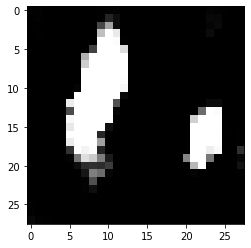

In [41]:
import matplotlib.pyplot as plt

plt.imshow(np.round(prediction * 255, 0), cmap="gray")